In [118]:
# %% [markdown]
# # OpenBB + QuantLib to generate risk free

# %%
from openbb import obb # In charge of the collection of SOFR data we will use to calculate risk free.
import pandas as pd # Used to interact with the data as dataframes 
import math # Supports calculations of specific mathematical functions in the paper
import numpy as np
from typing import Literal
from datetime import date, timedelta


# %% [markdown]
# ## Supporting functions

# %%
def load_sofr_history(start:str, end:str):
    """
    Obtains the SOFR data from FRED on the defined start and end dates.
    start and end must be in format YYYY-MM-DD.
    """
    df = obb.economy.fred_series("SOFR", start_date=start, end_date=end).to_dataframe()
    s = df/100
    s = s['SOFR']
    return s

def risk_free_value(
    length_years:float,
    day_count:int = Literal[365, 360]
):
    """
    Returns the exact risk free value for a given length in years and day count convention. 
    The risk free rate is calculated using the SOFR data obtained from FRED. 
    Day count convention can be either 365 or 360, which are the most common conventions used in financial modeling.
    The function assumes that the risk free rate is constant over the period, which is a common assumption in financial modeling.
    
    :param length_years: Length of the options contract in years.
    :type length_years: float
    :param day_count: 365 or 360, depending on the day count convention used in the financial modeling. Default is 365.
    :type day_count: int
    """

    sofr_history = load_sofr_history((date.today()-timedelta(days=7)).strftime("%Y-%m-%d"), date.today().strftime("%Y-%m-%d"))
    r = sofr_history.tail(1).iloc[0]
    return r



In [119]:
from openbb import obb
import pandas as pd
import matplotlib.pyplot as plt
# Get option chains for a specific stock for a specific date

def get_option_chains(symbol: str):
    """
    Get the latest option chains for a specific stock.

    Parameters:
    symbol (str): The stock symbol to get option chains for.

    """
    # Get the option chains for the specified stock and date
    option_chains = obb.derivatives.options.chains(symbol=symbol).to_dataframe()

    # Convert the result to a DataFrame
    

    return option_chains

In [120]:
import numpy as np
from scipy.stats import lognorm, norm
from scipy.optimize import minimize
from scipy.integrate import quad

def lognormal_pdf(s:float, a:float, b:float):
    """
    Probability density function of the Lognormal Distribution. Used in the calculation of the mixture distribution in page 12.
    s (float) : Value whose probability we want to calculate
    a (float) : Mean of log-price.
    b (float) : Standard Deviation of log-price
    """
    return lognorm.pdf(s, s=b, scale=np.exp(a))

def mixture_pdf(s:float, a1:float, b1:float, a2:float, b2:float, q:float):
    """
    Calculates the weighted pdf from two parametrised log-normal distributions. Used in page 12 as the final pdf for our prices.
    s (float) : Value whose probability we want to calculate
    a1 (float) : Mean of log-price for the first distribution.
    b1 (float) : Standard Deviation of log-price for the first distribution.
    a2 (float) : Mean of log-price for the second distribution.
    b2 (float) : Standard Deviation of log-price for the second distribution.
    q (float) : Weight assigned to the first distribution (the second will have weight 1-q).
    """
    return q * lognormal_pdf(s, a1, b1) + (1 - q) * lognormal_pdf(s, a2, b2)

def implied_mean(a1, b1, a2, b2, q):
    """
    Calculates the implied mean of the calculated mixed_distribution. Will be used in the minimisation problem.

    a1 (float) : Mean of log-price for the first distribution.
    b1 (float) : Standard Deviation of log-price for the first distribution.
    a2 (float) : Mean of log-price for the second distribution.
    b2 (float) : Standard Deviation of log-price for the second distribution.
    q (float) : Weight assigned to the first distribution (the second will have weight 1-q).
    """
    return q * np.exp(a1 + 0.5*b1**2) + (1-q) * np.exp(a2 + 0.5*b2**2)

def _call_lognormal(X, r, tau, a, b):
    """
    Closed-form European call price when ln(S_T) ~ N(a, b^2).
    """

    if b < 1e-10:
        F = np.exp(a)
        return np.exp(-r*tau) * max(F - X, 0.0)

    d1 = (a - np.log(X) + b*b) / b
    d2 = d1 - b

    return np.exp(-r*tau) * (
        np.exp(a + 0.5*b*b) * norm.cdf(d1)
        - X * norm.cdf(d2)
    )

def call_price_model(X, r, tau, a1, b1, a2, b2, q):
    """
    Call price under a two-lognormal mixture.
    """

    return (
        q * _call_lognormal(X, r, tau, a1, b1)
        + (1 - q) * _call_lognormal(X, r, tau, a2, b2)
    )

def put_price_model(X, r, tau, a1, b1, a2, b2, q, S0):
    """
    Put price via put-call parity.
    """

    call = call_price_model(X, r, tau, a1, b1, a2, b2, q)
    return call - S0 + X*np.exp(-r*tau)


def objective_from_chain(theta, chain, r):
    """
    Objective function we want to minimise to find the optimal vector theta = [a1, b1, a2, b2, q]

    :param theta: Vector containing the distribution parameters and weights [a1, b1, a2, b2, q].
    :param chain: Dataframe containing the option chain data we will use for the calculations
    :param r: Adjusted risk-free rate calculated for the defined timeframe
    """

    a1, b1, a2, b2, q = theta

    # enforce ordering (identifiability constraint)
    if a1 > a2:
        return 1e10

    tau = chain['dte'].iloc[0] / 365
    S0  = chain['underlying_price'].iloc[0]
    S_forward = S0 * np.exp(r * tau)

    error = 0.0

    for _, row in chain.iterrows():
        X = row['strike']
        market_price = 0.5 * (row['bid'] + row['ask'])

        if row['option_type'].lower() == 'call':
            model_price = call_price_model(X, r, tau, a1, b1, a2, b2, q)
        else:
            model_price = put_price_model(X, r, tau, a1, b1, a2, b2, q, S0)

        error += (model_price - market_price)**2

    mean_err = (implied_mean(a1, b1, a2, b2, q) - S_forward)**2

    return error + mean_err



In [121]:
r = risk_free_value(length_years=1/365)

In [122]:
chain = get_option_chains('AAPL')

In [123]:
chain['dte'].unique()

array([   1,    3,    6,    8,   10,   17,   24,   31,   38,   44,   59,
         87,  121,  150,  185,  213,  276,  304,  332,  485,  668,  703,
        759, 1032])

In [124]:
x0 = [0.9*np.log(chain['underlying_price'].mean()), 0.2,
      1.1*np.log(chain['underlying_price'].mean()), 0.5,
      0.5]

bounds = [
    (None, None), (1e-6, None),
    (None, None), (1e-6, None),
    (0, 1)
]
# Remove stale data from the chain
chain = chain[(chain['bid'] > 0) & (chain['ask'] > 0)]
chain = chain[chain['ask'] > chain['bid']]
chain = chain[abs(chain['strike'] - chain['underlying_price']) < 0.5*chain['underlying_price']]
chain = chain[chain['dte'] == 3] # Test with a single day of expiry.

res = minimize(objective_from_chain, x0, args=(chain, r), bounds=bounds)

a1, b1, a2, b2, q = res.x


C:\Users\alvar\AppData\Local\Temp\ipykernel_20308\1183266067.py:52: RuntimeWarning: overflow encountered in exp
  np.exp(a + 0.5*b*b) * norm.cdf(d1)
C:\Users\alvar\AppData\Local\Temp\ipykernel_20308\1183266067.py:37: RuntimeWarning: overflow encountered in exp
  return q * np.exp(a1 + 0.5*b1**2) + (1-q) * np.exp(a2 + 0.5*b2**2)
c:\Users\alvar\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [126]:
res.x

array([5.51936887, 0.52428765, 5.53735418, 0.02932803, 0.18178972])

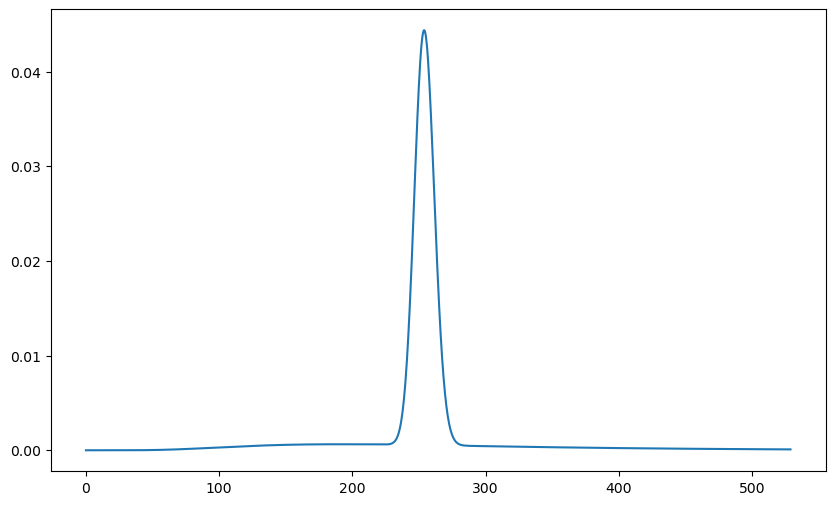

In [125]:
plot = plt.figure(figsize=(10, 6))
s_values = np.linspace(0, 2*chain['underlying_price'].iloc[0], 1000)
pdf_values = [mixture_pdf(s, a1, b1, a2, b2, q) for s in s_values]
plt.plot(s_values, pdf_values, label='Implied Price Distribution')
